In [87]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.datasets import fetch_20newsgroups


from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import silhouette_score

## Loading text data

In [74]:
def load_dataset():
    categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
    ]

    dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
    )
    return dataset

In [75]:

dataset = load_dataset()

labels = dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(dataset.data)} documents - {true_k} categories")

3387 documents - 4 categories


In [10]:
# samle data
sample = dataset.data[0]
sample

"My point is that you set up your views as the only way to believe.  Saying \nthat all eveil in this world is caused by atheism is ridiculous and \ncounterproductive to dialogue in this newsgroups.  I see in your posts a \nspirit of condemnation of the atheists in this newsgroup bacause they don'\nt believe exactly as you do.  If you're here to try to convert the atheists \nhere, you're failing miserably.  Who wants to be in position of constantly \ndefending themselves agaist insulting attacks, like you seem to like to do?!\nI'm sorry you're so blind that you didn't get the messgae in the quote, \neveryone else has seemed to."

## Vectorizer

#### HashingVectorizer
This strategy has several advantages:

* it is very low memory scalable to large datasets as there is no need to store a vocabulary dictionary in memory.

* it is fast to pickle and un-pickle as it holds no state besides the constructor parameters.

* it can be used in a streaming (partial fit) or parallel pipeline as there is no state computed during fit.

There are also a couple of cons (vs using a CountVectorizer with an in-memory vocabulary):

* there is no way to compute the inverse transform (from feature indices to string feature names) which can be a problem when trying to introspect which features are most important to a model.

* there can be collisions: distinct tokens can be mapped to the same feature index. However in practice this is rarely an issue if n_features is large enough (e.g. 2 ** 18 for text classification problems).

* no IDF weighting as this would render the transformer stateful.

In [56]:
# Convert a collection of text documents to a matrix of token occurrences.
hash_vec = HashingVectorizer(n_features=2**18)
hash_feat = hash_vec.fit_transform(dataset.data)

print('shape :', hash_feat.shape)
row, col = np.nonzero(hash_feat)
distinct_feat = np.unique(col)
print('unique terms : ', len(distinct_feat))

sparsity = len(distinct_feat) / hash_feat.shape[1]
print('Sparsity :',sparsity)

shape : (3387, 262144)
unique terms :  31742
Sparsity : 0.12108612060546875


#### TfidfVectorizer

* ignore the terms that appear in more than 50% of the documents (as set by max_df=0.5) 
* ignore the terms that are not present in at least 5 documents (set by min_df=5)


In [18]:
tf_idf = TfidfVectorizer(min_df=5, max_df=0.5, stop_words='english')
feat_tf_id = tf_idf.fit_transform(dataset.data)
print('Shape : ',feat_tf_id.todense().shape)

Shape :  (3387, 7929)


* the resulting number of unique terms n_features is around 8,000. 
* We can additionally quantify the sparsity of the X_tfidf matrix as the fraction of non-zero entries devided by the total number of elements.
* We find that around 0.7% of the entries of the X_tfidf matrix are non-zero.



In [55]:
# sparsity = total non-zero elements divided by total elements
sparsity = feat_tf_id.nnz  / (feat_tf_id.shape[0] * feat_tf_id.shape[1])
print('Sparsity :', sparsity)

Sparsity : 0.006944679498515073


### Why is sparsity important when working with kmeans clustering?
####  On sparse high-dimensional data such as text vectorized using the Bag of Words approach, k-means can initialize centroids on extremely isolated data points. Those data points can stay their own centroids all along.

#### As both KMeans and MiniBatchKMeans optimize a non-convex objective function, their clustering is not guaranteed to be optimal for a given random init. So on sparse high dimensional data we have to increase the `init` param to avoid convergence to a local minimum.

#### the more sparse and high-dimensional the problem is, the higher is the need to run the algorithm with different centroid seeds to ensure a global minimal inertia.

In [62]:

for seed in range(5):
    kmeans = KMeans(n_clusters=true_k, n_init='auto', random_state=seed)
    kmeans.fit(feat_tf_id)
    cluster_id, cluster_size = np.unique(kmeans.labels_, return_counts=True)
    print('cluster assignment :',cluster_size)

true_cluster_id, true_cluster_size = np.unique(dataset.target, return_counts=True)
print('True cluster assignment :', true_cluster_size)


cluster assignment : [   1    1 3384    1]
cluster assignment : [1597  732  233  825]
cluster assignment : [2004  446  646  291]
cluster assignment : [1695  649  446  597]
cluster assignment : [ 254 2117  459  557]
True cluster assignment : [799 973 987 628]


**To avoid this problem, one possibility is to increase the number of runs with independent random initiations `n_init`. In such case the clustering with the best inertia (objective function of k-means) is chosen.**

**Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline.**

### Quantifying the quality of clustering

Clustering algorithms are fundamentally unsupervised learning methods. However, since we happen to have class labels for this specific dataset, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the following:

* `homogeneity` --> which quantifies how much clusters contain only members of a single class;

* `completeness` --> which quantifies how much members of a given class are assigned to the same clusters;

* `V-measure` --> the harmonic mean of completeness and homogeneity;

* `Rand-Index` --> which measures how frequently pairs of data points are grouped consistently according to the result of the clustering algorithm and the ground truth class assignment;

* `Adjusted Rand-Index` --> a chance-adjusted Rand-Index such that random cluster assignment have an ARI of 0.0 in expectation. Adjusted Rand-Index close to 0.0 correspond to a random labeling

* If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the `Silhouette Coefficient` comes in handy.

In [19]:
def evaluate_clustering(kmeans, data, n_runs=5):

    for seed in range(5):
        kmeans.fit(data)
        clustering_metrics = {
        "homogeneity_score" : homogeneity_score(labels, kmeans.labels_),
        "completeness_score" : completeness_score(labels, kmeans.labels_),
        "v_measure_score" : v_measure_score(labels, kmeans.labels_),
        "adjusted_rand_score"  : adjusted_rand_score(labels, kmeans.labels_),
        "adjusted_mutual_info_score" : adjusted_mutual_info_score(labels, kmeans.labels_),
        "silhouette_score" : silhouette_score(data, kmeans.labels_, sample_size=3000)
        }

    return clustering_metrics

# **Keep in mind that the class labels may not reflect accurately the document topics 
# and therefore metrics that use labels are not necessarily the best to evaluate 
# the quality of our clustering pipeline.**

In [20]:
kmeans = KMeans(n_clusters=true_k, n_init='auto' , random_state=42)

kmeans_tf_idf = evaluate_clustering(kmeans, feat_tf_id)

In [93]:
def plot_performance(result_dict, title):
    plt.barh(list(result_dict.keys()), list(result_dict.values()));
    plt.title(f'kmeans clustering using : {title}')

plot_performance(kmeans_tf_idf, 'TF-IDF features')

<img src='./plots/kmeans-clustering-using-tfidf-features-performance.png'>

* Keep in mind that the class labels may not reflect accurately the document topics and therefore metrics that use labels are not necessarily the best to evaluate the quality of our clustering pipeline.

#### Can we improve our clustering ?

### Latent Semantic Analysis (LSA)
* A `n_init=1` can still be used as long as the dimension of the vectorized space is reduced first to make k-means more stable.
* For such purpose we use TruncatedSVD, which works on term count/tf-idf matrices. 
* Since SVD results are not normalized, we redo the normalization to improve the KMeans result. 
* Using SVD to reduce the dimensionality of TF-IDF document vectors is often known as latent semantic analysis 

In [26]:
# Singular Value Decomposition
svd = TruncatedSVD(n_components=100)
# Normalize samples individually to unit norm.
norm = Normalizer(copy=False)

In [27]:
# Latent Semantic Analysis (LSA)
lsa = make_pipeline(svd, norm)

X_lsa = lsa.fit_transform(feat_tf_id)

In [28]:
print('Shape of LSA features :',X_lsa.shape)

Shape of LSA features : (3387, 100)


#### Percentage of variance explained by each of the selected components.

In [20]:
plt.bar(range(100) ,lsa[0].explained_variance_ratio_);
plt.title(f'Explained variance of the SVD step: {lsa[0].explained_variance_ratio_.sum()*100 :0.2f}%');

<img src='./plots/Explained-variance-of-the-SVD-step.png'>

In [29]:
kmeans = KMeans(n_clusters=true_k, n_init=1, random_state=42)
kmeans_lsa = evaluate_clustering(kmeans, X_lsa)

In [ ]:
plot_performance(kmeans_lsa, 'LSA features')

<img src='./plots/kmeans-clustering-using-LSA-features-performance.png'>

* We can observe that clustering on the LSA representation of the document is significantly faster 
    * both because of `n_init=1` and because the dimensionality of the LSA feature space is much smaller. 
* Furthermore, all the clustering evaluation metrics have improved.


### Lets repeat the experiment with MiniBatchKMeans.

In [40]:
mini_kmeans = MiniBatchKMeans(n_clusters=true_k, n_init=1, batch_size=1024, init_size=1024)
mini_kmeans_lsa = evaluate_clustering(mini_kmeans, X_lsa)

plot_performance(mini_kmeans_lsa, 'LSA features and mini batching')

<img src='./plots/kmeans-clustering-using-LSA-features-MiniBatchKmeans-performance.png'>

### Top terms per cluster
Since both `TruncatedSVD` and `TfidfVectorizer` can be inverted we can identify the cluster centers, which provide an intuition of the most influential words for each cluster. 

* `inverse_transform(X)` : Transform X back to its original space.

In [80]:
# dataset
dataset = load_dataset()

# pipeline
lsa = make_pipeline(
    TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english'),
    TruncatedSVD(n_components=100, random_state=42), 
    Normalizer(copy=False), 
    KMeans(n_clusters=true_k, n_init=1, random_state=42))

# fit using raw data
lsa.fit(dataset.data)

cluster_centers = lsa[-1].cluster_centers_
original_space_centroid = lsa[1].inverse_transform(cluster_centers)

print('Shape of orignal space centroids :',original_space_centroid.shape)

Shape of orignal space centroids : (4, 7929)


In [81]:
## slicing from 1st to last in steps of 1 in reverse order
order_centroid = original_space_centroid.argsort()[:, ::-1]

In [82]:
# terms : vocab 
terms = lsa[0].get_feature_names_out()

#### Words assigned to cluster

In [83]:
for i in range(true_k):
    print('Cluster :',i)
    for order in order_centroid[i, :10]:
        print(terms[order], end=' ')
    print()
    
        

Cluster : 0
graphics thanks image program file files know looking help format 
Cluster : 1
space launch orbit shuttle nasa earth moon like mission just 
Cluster : 2
god people jesus bible believe don think religion say christian 
Cluster : 3
just don think like know time ve say does good 


## HashingVectorizer

* A HashingVectorizer  does not provide IDF weighting as this is a stateless model (the fit method does nothing). 
* When IDF weighting is needed it can be added by pipelining the HashingVectorizer output to a TfidfTransformer instance. 
* Add LSA in to the pipeline for reducing the dimensionality and sparcity of the hashed vector space.

In [89]:
hash_pipe = make_pipeline(
    HashingVectorizer(n_features=2**18, stop_words='english'),
    TfidfTransformer(), # TF-IDF transfomer 
    TruncatedSVD(n_components=100),
    Normalizer(copy=False)
)

X_hashed_lsa = hash_pipe.fit_transform(dataset.data)

In [94]:
kmeans = KMeans(n_clusters=true_k, n_init='auto', random_state=42)
X_hashed_lsa_score = evaluate_clustering(kmeans, X_hashed_lsa)

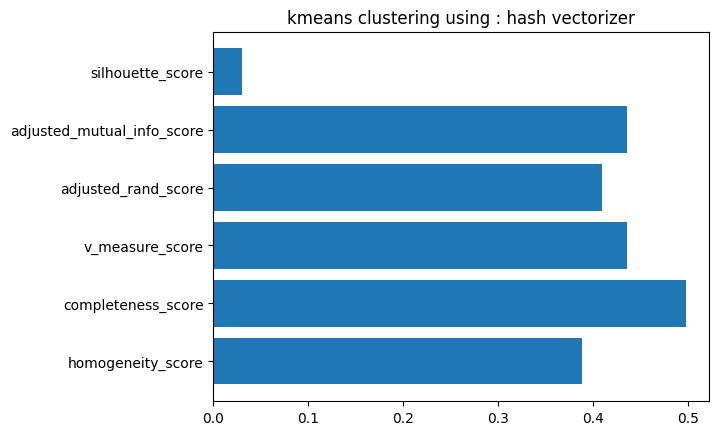

In [95]:
plot_performance(X_hashed_lsa_score, 'hash vectorizer')